<a href="https://colab.research.google.com/github/taichihaya/test/blob/master/livedoor_news_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 日本語BERTでlivedoorニュースを教師あり学習で分類

In [1]:
# 乱数シードの固定

import os
import random
import numpy as np
import torch
import tarfile
import os
import glob
import pandas as pd

SEED_VALUE = 1234  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  # PyTorchを使う場合


## 準備1：Livedoorニュースをダウンロードしてtsvファイル化

参考：https://github.com/yoheikikuta/bert-japanese/blob/master/notebook/finetune-to-livedoor-corpus.ipynb


In [2]:
%%capture
# Livedoorニュースのファイルをダウンロード
! wget "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"

# 解凍
tar = tarfile.open("ldcc-20140209.tar.gz", "r:gz")
tar.extractall("./data/livedoor/")
tar.close()

# ファイルの中身を確認してみる
file_name = "./data/livedoor/text/movie-enter/movie-enter-6255260.txt"

# 本文を取得する前処理関数を定義

def extract_main_txt(file_name):
    with open(file_name) as text_file:
        # 今回はタイトル行は外したいので、3要素目以降の本文のみ使用
        text = text_file.readlines()[3:]

        # 3要素目以降にも本文が入っている場合があるので、リストにして、後で結合させる
        text = [sentence.strip() for sentence in text]  # 空白文字(スペースやタブ、改行)の削除
        text = list(filter(lambda line: line != '', text))
        text = ''.join(text)
        text = text.translate(str.maketrans(
            {'\n': '', '\t': '', '\r': '', '\u3000': ''}))  # 改行やタブ、全角スペースを消す
        return text

# リストに前処理した本文と、カテゴリーのラベルを追加していく

list_text = []
list_label = []

categories = [name for name in os.listdir(
    "./data/livedoor/text/") if os.path.isdir("./data/livedoor/text/"+name)]

for cat in categories:
    text_files = glob.glob(os.path.join("./data/livedoor/text", cat, "*.txt"))

    # 前処理extract_main_txtを実施して本文を取得
    body = [extract_main_txt(text_file) for text_file in text_files]

    label = [cat] * len(body)  # bodyの数文だけカテゴリー名のラベルのリストを作成

    list_text.extend(body)  # appendが要素を追加するのに対して、extendはリストごと追加する
    list_label.extend(label)

# pandasのDataFrameにする
df = pd.DataFrame({'text': list_text, 'label': list_label})

# カテゴリーの辞書を作成
dic_id2cat = dict(zip(list(range(len(categories))), categories))
dic_cat2id = dict(zip(categories, list(range(len(categories)))))

# DataFrameにカテゴリーindexの列を作成
df["label_index"] = df["label"].map(dic_cat2id)

# label列を消去し、text, indexの順番にする
df = df.loc[:, ["text", "label_index"]]

# 順番をシャッフルする
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

# tsvファイルで保存する

# 全体の2割の文章数
len_0_2 = len(df) // 5

# 前から2割をテストデータとする
test = df[:len_0_2]
test.to_csv("./test.tsv", sep='\t', index=False)

# 前2割からを訓練&検証データとする
train = df[len_0_2:]
train.to_csv("./train_eval.tsv", sep='\t', index=False)

## TFIDF

In [3]:
# MeCabの用意
%%capture
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

In [4]:
import MeCab

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
train_eval = pd.read_csv("./train_eval.tsv",sep="\t")
test = pd.read_csv("./test.tsv",sep="\t")
train_eval.label_index.value_counts()

4    730
2    716
1    697
8    693
7    691
6    691
0    665
5    617
3    401
Name: label_index, dtype: int64

In [7]:
target = 3
train_eval["target"] = (train_eval.label_index==target)*1
test["target"] = (test.label_index==target)*1
train_eval.target.value_counts(normalize=True)

0    0.932045
1    0.067955
Name: target, dtype: float64

In [8]:
# Mecabで必要な品詞に絞る
def mplg(text):
    word_list = ""
    m=MeCab.Tagger()
    m1=m.parse(text)
    for row in m1.split("\n"):
        word =row.split("\t")[0]#タブ区切りになっている１つ目を取り出す。ここには形態素が格納されている
        if word == "EOS":
            break
        else:
            pos = row.split("\t")[1]#タブ区切りになっている2つ目を取り出す。ここには品詞が格納されている
            slice = pos[:2]
            if slice in ["名詞","動詞","助動詞"]:
                word_list = word_list +" "+ word
    return word_list

import re
def replace_number_to_zero(text):
    changed_text = re.sub(r'[0-9]+', "0", text) #半角
    changed_text = re.sub(r'[０-９]+', "0", changed_text) #全角
    return changed_text

train_eval["text_macab"] = train_eval.text.apply(mplg)
train_eval["text_macab"] = train_eval.text_macab.apply(replace_number_to_zero)

test["text_macab"] = test.text.apply(mplg)
test["text_macab"] = test.text_macab.apply(replace_number_to_zero)

In [9]:
# tfidf
tfidf = TfidfVectorizer(min_df=0.02,
                        max_df=0.90,
                        ngram_range=(1,3))
tfidf.fit(train_eval["text_macab"])

train_tf_vec = tfidf.transform(train_eval["text_macab"])
test_tf_vec = tfidf.transform(test["text_macab"])

from sklearn.decomposition import TruncatedSVD
# SVD
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
svd.fit(train_tf_vec.toarray())

train_X = svd.transform(train_tf_vec.toarray())
train_df = pd.DataFrame(train_X,columns=[f"pc_{i}" for i in range(1,51)])
train_df["target"] = train_eval["target"]

test_X = svd.transform(test_tf_vec.toarray())
test_df = pd.DataFrame(test_X,columns=[f"pc_{i}" for i in range(1,51)])
test_df["target"] = test["target"]

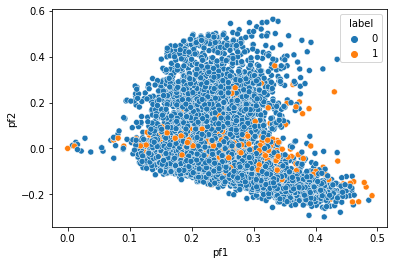

In [10]:
# 2次元圧縮時のプロット
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

svd_2d = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_2d.fit(train_tf_vec.toarray())
X = svd_2d.transform(train_tf_vec.toarray())
scatter_df = pd.DataFrame(X,columns=["pf1","pf2"])
scatter_df["label"] = train_eval["target"]
scatter_df
sns.scatterplot(data=scatter_df, x="pf1", y="pf2", hue="label")

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df.drop("target",axis=1), 
                                                    train_df["target"],
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=train_df["target"])

In [12]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.get_label()
  def fl(x,t):
  	p = 1/(1+np.exp(-x))
  	return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
  partial_fl = lambda x: fl(x, y_true)
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
  return grad, hess

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.get_label()
  p = 1/(1+np.exp(-y_pred))
  loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
  # (eval_name, eval_result, is_higher_better)
  return 'focal_loss', np.mean(loss), False

def focal_loss_lgb_f1_score(preds, lgbDataset):
  preds = sigmoid(preds)
  binary_preds = [int(p>0.5) for p in preds]
  y_true = lgbDataset.get_label()
  return 'f1', f1_score(y_true, binary_preds), True

In [13]:
import lightgbm as lgb 
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

lgbm_params = {
    'application': 'binary',     # Binary classification
    'learning_rate': 0.01,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15
              }

from scipy.misc import derivative
focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=1.)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=1.)

clf = lgb.train(train_set=lgb_train,
                params=lgbm_params,
                valid_sets=[lgb_train, lgb_eval], 
                valid_names=['Train', 'Test'],
                num_boost_round=1000,
                early_stopping_rounds=100,
                verbose_eval=100,
                fobj=focal_loss,
                feval=focal_loss_eval
                )

Training until validation scores don't improve for 100 rounds.
[100]	Train's focal_loss: 0.081268	Test's focal_loss: 0.0850791
[200]	Train's focal_loss: 0.0342878	Test's focal_loss: 0.0413847
[300]	Train's focal_loss: 0.0169733	Test's focal_loss: 0.0278456
[400]	Train's focal_loss: 0.0091602	Test's focal_loss: 0.0234308
[500]	Train's focal_loss: 0.00507499	Test's focal_loss: 0.0221041
[600]	Train's focal_loss: 0.00285178	Test's focal_loss: 0.0220913
Early stopping, best iteration is:
[533]	Train's focal_loss: 0.00418286	Test's focal_loss: 0.0219705


In [14]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(learning_rate=0.01,n_estimators=1000,)
xgb_model.fit(X_train,
              y_train,
              early_stopping_rounds=100,
              eval_set=[[X_test, y_test]],
              verbose=100,
              eval_metric="aucpr"
              )

[0]	validation_0-aucpr:0.433339
Will train until validation_0-aucpr hasn't improved in 100 rounds.
[100]	validation_0-aucpr:0.534265
[200]	validation_0-aucpr:0.610819
[300]	validation_0-aucpr:0.631521
[400]	validation_0-aucpr:0.663769
[500]	validation_0-aucpr:0.671246
[600]	validation_0-aucpr:0.674335
[700]	validation_0-aucpr:0.679576
[800]	validation_0-aucpr:0.684128
[900]	validation_0-aucpr:0.688702
[999]	validation_0-aucpr:0.693559


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [15]:
predict_df = test_df[["target"]].copy()
predict_df["pred"] = clf.predict(test_df.drop("target",axis=1),num_iteration=clf.best_iteration)
# predict_df["pred"] = xgb_model.predict_proba(test_df.drop("target",axis=1))[:,1]
# predict_df["pred"] = na_clf.predict_proba(test_df.drop("target",axis=1))[:,1]
predict_df["pred_rank"] = predict_df.pred.rank(ascending=False)

In [16]:
import math
target_num = sum(test_df.target)
by_70 = math.ceil(target_num*0.7)
print(target_num)
correct_num = predict_df[predict_df.pred_rank <= target_num].target.sum()
print(correct_num)
print(correct_num/target_num)

111
76
0.6846846846846847


In [17]:
predict_df = predict_df.sort_values("pred_rank")
predict_df["target_cumsum"] = predict_df.target.cumsum()
thres_rank = predict_df.query("target_cumsum==@by_70 and target==1").pred_rank.values[0]
predict_df["predict_cat"] = (predict_df.pred_rank <= thres_rank)*1

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predict_df["target"],predict_df["predict_cat"])

array([[1328,   36],
       [  33,   78]])